# House Building with worker skills

This tutorial includes everything you need to set up decision optimization engines, build constraint programming models.


When you finish this tutorial, you'll have a foundational knowledge of _Prescriptive Analytics_.

>This notebook is part of the **[Prescriptive Analytics for Python](https://rawgit.com/IBMDecisionOptimization/docplex-doc/master/docs/index.html)**

>It requires a valid subscription to **Decision Optimization on the Cloud**. Try it for free [here](https://developer.ibm.com/docloud)


Table of contents:

-  [Describe the business problem](#Describe-the-business-problem)
*  [How decision optimization (prescriptive analytics) can help](#How--decision-optimization-can-help)
*  [Use decision optimization](#Use-decision-optimization)
    *  [Step 1: Download the library](#Step-1:-Download-the-library)
    *  [Step 2: Set up the engines](#Step-2:-Set-up-the-prescriptive-engine)
    -  [Step 3: Model the Data](#Step-3:-Model-the-data)
    -  [Step 4: Set up the prescriptive model](#Step-4:-Set-up-the-prescriptive-model)
        * [Define the decision variables](#Define-the-decision-variables)
        * [Express the business constraints](#Express-the-business-constraints)
        * [Express the objective](#Express-the-objective)
        * [Solve with Decision Optimization solve service](#Solve-with-Decision-Optimization-solve-service)
    *  [Step 5: Investigate the solution and run an example analysis](#Step-5:-Investigate-the-solution-and-then-run-an-example-analysis)
*  [Summary](#Summary)
****

### Describe the business problem

* This is a problem of building five houses in different locations; the masonry, roofing, painting, etc. must be scheduled. Some tasks must necessarily take place before others and these requirements are expressed through precedence constraints.

* There are three workers, and each worker has a given skill level for each task. Each task requires one worker; the worker assigned must have a non-null skill level for the task. A worker can be assigned to only one task at a time.

* Each house has a deadline. 

* The objective is to maximize the skill levels of the workers assigned to the tasks.

*****
## How  decision optimization can help
* Prescriptive analytics technology recommends actions based on desired outcomes, taking into account specific scenarios, resources, and knowledge of past and current events. This insight can help your organization make better decisions and have greater control of business outcomes.  

* Prescriptive analytics is the next step on the path to insight-based actions. It creates value through synergy with predictive analytics, which analyzes data to predict future outcomes.  

* Prescriptive analytics takes that insight to the next level by suggesting the optimal way to handle that future situation. Organizations that can act fast in dynamic conditions and make superior decisions in uncertain environments gain a strong competitive advantage.  
<br/>

+ For example:
    + Automate complex decisions and trade-offs to better manage limited resources.
    + Take advantage of a future opportunity or mitigate a future risk.
    + Proactively update recommendations based on changing events.
    + Meet operational goals, increase customer loyalty, prevent threats and fraud, and optimize business processes.


<h2>About Detailed Scheduling concepts</h2>
<p>
<ul>
<li> Scheduling consists of assigning starting and completion times to a set of activities while satisfying different types of constraints (resource availability, precedence relationships, … ) and optimizing some criteria (minimizing tardiness, …)
<!-- <img src = "./house_building_utils/activity.png" > -->
<img src = "https://github.com/IBMDecisionOptimization/docplex-examples/blob/master/examples/cp/jupyter/house_building_utils/activity.PNG?raw=true " >
<li> Time is considered as a continuous dimension: domain of possible start/completion times for an activity is potentially very large
<li>Beside start and completion times of activities, other types of decision variables are often involved in real industrial scheduling problems (resource allocation, optional activities …)
</ul>

## Use decision optimization

### Step 1: Download the library

Run the following code to install Decision Optimization CPLEX Modeling library.  The *DOcplex* library contains the two modeling packages, Mathematical Programming and Constraint Programming, referred to earlier.

In [29]:
import sys
try:
    import docplex.cp
except:
    if hasattr(sys, 'real_prefix'):
        #we are in a virtual env.
        !pip install docplex
    else:
        !pip install --user docplex

Note that the more global package <i>docplex</i> contains another subpackage <i>docplex.mp</i> that is dedicated to Mathematical Programming, another branch of optimization.

### Step 2: Set up the prescriptive engine

* Subscribe to the [Decision Optimization on Cloud solve service](https://developer.ibm.com/docloud).
* Get the service URL and your personal API key.

In [30]:
# Initialize IBM Decision Optimization credentials
SVC_URL = "" # ENTER YOUR URL HERE
SVC_KEY = "" # ENTER YOUR KEY HERE

And for display of the solution, ensure last version of matplotlib is available:

In [31]:
try:
   import matplotlib
   if matplotlib.__version__ < "1.4.3":
        !pip install --upgrade matplotlib
except:
   !pip install --user matplotlib

Now, we need to import all required modeling functions that are provided by the <i>docplex.cp</i> package:

In [32]:
from docplex.cp.model import *
from sys import stdout
from collections import namedtuple

### Step 3: Model the data

Planning contains the number of houses and the max amount of periods (<i>days</i>) for our schedule

In [33]:
NB_HOUSES = 5
MAX_AMOUNT_OF_PERIODS = 318
HOUSES = range(1, NB_HOUSES + 1)

All tasks must start and end between 0 and the max amount of periods

In [34]:
period_domain = (0, MAX_AMOUNT_OF_PERIODS)

For each task type in the house building project, the following table shows the duration of the task in days along with the tasks that must be finished before the task can start. A worker can only work on one task at a time; each task, once started, may not be interrupted.
<p>

| *Task* | *Duration* | *Preceding tasks* |
|---|---|---|
| masonry 	| 35 |	|
| carpentry | 15 | masonry |
| plumbing 	| 40 | masonry |
| ceiling 	| 15 | masonry |
| roofing 	| 5  | carpentry |
| painting 	| 10 | ceiling |
| windows 	| 5  | roofing |
| facade 	| 10 | roofing, plumbing |
| garden 	| 5  | roofing, plumbing |
| moving 	| 5  | windows, facade, garden, painting | 

##### Tasks' durations

In [35]:
Task = (namedtuple("Task", ["name", "duration"]))
TASKS = {Task("masonry",   35),
         Task("carpentry", 15),
         Task("plumbing",  40),
         Task("ceiling",   15),
         Task("roofing",    5),
         Task("painting",  10),
         Task("windows",    5),
         Task("facade",    10),
         Task("garden",     5),
         Task("moving",     5),
        }

##### The tasks precedences

In [36]:
TaskPrecedence = (namedtuple("TaskPrecedence", ["beforeTask", "afterTask"]))
TASK_PRECEDENCES = {TaskPrecedence("masonry",   "carpentry"),
                    TaskPrecedence("masonry",   "plumbing"),
                    TaskPrecedence("masonry",   "ceiling"),
                    TaskPrecedence("carpentry", "roofing"),
                    TaskPrecedence("ceiling",   "painting"),
                    TaskPrecedence("roofing",   "windows"),
                    TaskPrecedence("roofing",   "facade"),
                    TaskPrecedence("plumbing",  "facade"),
                    TaskPrecedence("roofing",   "garden"),
                    TaskPrecedence("plumbing",  "garden"),
                    TaskPrecedence("windows",   "moving"),
                    TaskPrecedence("facade",    "moving"),
                    TaskPrecedence("garden",    "moving"),
                    TaskPrecedence("painting",  "moving"),
                   }

There are three workers with varying skill levels in regard to the ten tasks. If a worker has a skill level of zero for a task, he may not be assigned to the task.
<p>

| *Task* | *Joe* | *Jack* | *Jim* |
|---|---|---|---|
|masonry   |9 |	5 |	0|
|carpentry |7 |	0 |	5|
|plumbing  |0 |	7 |	0|
|ceiling   |5 |	8 |	0|
|roofing   |6 |	7 |	0|
|painting  |0 |	9 |	6|
|windows   |8 |	0 |	5|
|façade    |5 |	5 |	0|
|garden    |5 |	5 |	9|
|moving    |6 |	0 |	8|

##### Workers Names

In [37]:
WORKERS = {"Joe", "Jack", "Jim"}

##### Workers Name and level for each of there skill

In [38]:
Skill = (namedtuple("Skill", ["worker", "task", "level"]))
SKILLS = {Skill("Joe",  "masonry",   9),
          Skill("Joe",  "carpentry", 7),
          Skill("Joe",  "ceiling",   5),
          Skill("Joe",  "roofing",   6),
          Skill("Joe",  "windows",   8),
          Skill("Joe",  "facade",    5),
          Skill("Joe",  "garden",    5),
          Skill("Joe",  "moving",    6),
          Skill("Jack", "masonry",   5),
          Skill("Jack", "plumbing",  7),
          Skill("Jack", "ceiling",   8),
          Skill("Jack", "roofing",   7),
          Skill("Jack", "painting",  9),
          Skill("Jack", "facade",    5),
          Skill("Jack", "garden",    5),
          Skill("Jim",  "carpentry", 5),
          Skill("Jim",  "painting",  6),
          Skill("Jim",  "windows",   5),
          Skill("Jim",  "garden",    9),
          Skill("Jim",  "moving",    8)
          }

##### Utility functions

find_tasks: returns the task it refers to in the TASKS vector

In [39]:
def find_tasks(name):
    return next(t for t in TASKS if t.name == name)

find_skills: returns the skill it refers to in the SKILLS vector

In [40]:
def find_skills(worker, task):
    return next(s for s in SKILLS if (s.worker == worker) and (s.task == task))

find_max_level_skill: returns the tuple "skill" where the level is themaximum for a given task

In [41]:
def find_max_level_skill(task):
    st = [s for s in SKILLS if s.task == task]
    return next(sk for sk in st if sk.level == max([s.level for s in st]))

### Step 4: Set up the prescriptive model

<h3>Create the model container</h3>
<p>
The model is represented by a Python object that is filled with the different model elements (variables, constraints, objective function, etc). The first thing to do is then to create such an object:

In [42]:
mdl = CpoModel(name="HouseBuilding")

#### Define the decision variables

<h5><i><font color=blue>Concept: interval variable</font></i></h5>
<p>
<ul>
<li> What for?<br>
<blockquote> Modeling an interval of time during which a particular property holds <br>
(an activity executes, a resource is idle, a tank must be non-empty, …)</blockquote> 
<li> Example:<br>
<blockquote><code><font color=green>interval_var(start=(0,1000), end=(0,1000), size=(10,20))</font></code>
</blockquote> 
<!-- <img src = "./house_building_utils/intervalVar.png" > -->
<img src = "https://github.com/IBMDecisionOptimization/docplex-examples/blob/master/examples/cp/jupyter/house_building_utils/intervalVar.PNG?raw=true" >
<li>Properties:
<ul>
<li>The **value** of an interval variable is an integer interval [start,end) 
<li>**Domain**  of possible values: [0,10), [1,11), [2,12),...[990,1000), [0,11),[1,12),...
<li>Domain of interval variables is represented **compactly** in CP Optimizer (a few bounds: smin, smax, emin, emax, szmin, szmax)
</ul>
</ul>

For each house, an interval variable is created for each task.<br>
This interval must start and end inside the period_domain and its duration is set as the value stated in TASKS definition.

In [43]:
tasks = {}   # dict of interval variable for each house and task
for house in HOUSES:
    for task in TASKS:
        tasks[(house, task)] = interval_var(start=period_domain,
                                            end=period_domain,
                                            size=task.duration,
                                            name="house {} task {}".format(house, task))

<h5><i><font color=blue>Concept: optional interval variable</font></i></h5>
<p>
<ul>
<li>Interval variables can be defined as being **optional** that is, it is part of the decisions of the problem to decide whether the interval will be **present** or **absent** in the solution<br>
<li> What for?<br>
<blockquote> Modeling optional activities, alternative execution modes for activities, and … most of the discrete decisions in a schedule</blockquote> 
<li> Example:<br>
<blockquote><code><font color=green>interval_var(</font><font color=red>optional=True</font><font color=green>, start=(0,1000), end=(0,1000), size=(10,20))</font></code>
</blockquote> 
<li>Properties:
<ul>
<li>An optional interval variable has an additional possible value in its domain (absence value)
<li>**Optionality** is a powerful property that you must learn to leverage in your models
</ul>
</ul>

For each house, an __optional__ interval variable is created for each skill.<br>
Skill being a tuple (worker, task, level), this means that for each house, an __optional__ interval variable is created for each couple worker-task such that the skill level of this worker for this task is > 0.<p>
The "**set_optional()**" specifier allows a choice between different variables, thus between different couples house-skill.
This means that the engine decides if the interval will be present or absent in the solution.

In [44]:
wtasks = {}  # dict of interval variable for each house and skill
for house in HOUSES:
    for skill in SKILLS:
        iv = interval_var(name='H' + str(house) + '-' + skill.task + '(' + skill.worker + ')')
        iv.set_optional()
        wtasks[(house, skill)] = iv

#### Express the business constraints

<h5>Temporal constraints</h5>

<h5><i><font color=blue>Concept: precedence constraint</font></i></h5>
<p>
<ul>
<li> What for?<br>
<ul>
<li>Modeling temporal constraints between interval variables
<li>Modeling constant or variable minimal delays
</ul>
<li>Properties
<blockquote>Semantic of the constraints handles optionality (as for all constraints in CP Optimizer).<br>
Example of endBeforeStart:<br>
<code><font color=green>end_before_start(a,b,z)</font></code><br>
present(a) <font color=red>AND</font> present(b)  &Implies;  end(a)+z &LessSlantEqual; start(b) 
</blockquote>
<ul>

The tasks in the model have precedence constraints that are added to the model.

In [45]:
for h in HOUSES:
    for p in TASK_PRECEDENCES:
        mdl.add(end_before_start(tasks[(h, find_tasks(p.beforeTask))], tasks[(h, find_tasks(p.afterTask))]))

<h5>Alternative workers</h5>

<h5><i><font color=blue>Concept: alternative constraint</font></i></h5>
<p>
<ul>
<li> What for?<br>
<ul>
<li>Modeling alternative resource/modes/recipes 
<li>In general modeling a discrete selection in the schedule 
</ul>
<li> Example:<br>
<blockquote><code><font color=green>alternative(a,[b1,...,bn])</font></code>
</blockquote> 
<!-- <img src = "./house_building_utils/alternative.png" > -->
<img src = "https://github.com/IBMDecisionOptimization/docplex-examples/blob/master/examples/cp/jupyter/house_building_utils/alternative.PNG?raw=true" >
<li>Remark: Master interval variable **a** can of course be optional
</ul>

To constrain the solution so that exactly one of the interval variables wtasks associated with a given task of a given house is to be present in the solution, an "**alternative**" constraint is used.

In [46]:
for h in HOUSES:
    for t in TASKS:
        mdl.add(alternative(tasks[(h, t)], [wtasks[(h, s)] for s in SKILLS if (s.task == t.name)], 1))

<h5>No overlap constraint</h5>

<h5><i><font color=blue>Concept: No-overlap constraint</font></i></h5>
<p>
<ul>
<li> Constraint noOverlap schedules a group of interval variables in such a way that they do not overlap in time.
<li> Absent interval variables are ignored.
<li>It is possible to constrain minimum delays between intervals using transition matrix.
<li>It is possible to constraint the first, last in the sequence or next or preceding interval
</ul>
<!-- <img src = "./house_building_utils/noOverlap.png" > -->
<img src = "https://github.com/IBMDecisionOptimization/docplex-examples/blob/master/examples/cp/jupyter/house_building_utils/noOverlap.PNG?raw=true" >

To add the constraints that a given worker can be assigned only one task at a given moment in time, a  **noOverlap** constraint is used.

In [47]:
for w in WORKERS:
    mdl.add(no_overlap([wtasks[(h, s)] for h in HOUSES for s in SKILLS if s.worker == w]))

#### Express the objective

The presence of an interval variable in wtasks in the solution must be accounted for in the objective. Thus for each of these possible tasks, the cost is incremented by the product of the skill level and the expression representing the presence of the interval variable in the solution.<p>
The objective of this problem is to maximize the skill level used for all the tasks.

In [48]:
obj = sum([s.level * presence_of(wtasks[(h, s)]) for s in SKILLS for h in HOUSES])
mdl.add(maximize(obj))

The model is now completely defined. It is time to solve it !
<p>
To use the CP Optimizer solver available on the IBM Decision Optimization on Cloud service:
<ul>
<li> Register for the DOcplexcloud free trial and use it free for 30 days by using https://developer.ibm.com/docloud/try-docloud-free
<li> Get your access credentials (base URL and access key) by going this page: http://developer.ibm.com/docloud/docs/api-key/
</ul>
<p>

#### Solve with Decision Optimization solve service

In [49]:
# Solve the model
print("\nSolving model....")
msol = mdl.solve(url=SVC_URL, key=SVC_KEY, TimeLimit=10)


Solving model....


### Step 5: Investigate the solution and then run an example analysis

In [50]:
print("Solve status: " + msol.get_solve_status())
if msol.is_solution():
    stdout.write("Solve time: " + str(msol.get_solve_time()) + "\n")
    # Sort tasks in increasing begin order
    ltasks = []
    for hs in HOUSES:
        for tsk in TASKS:
            (beg, end, dur) = msol[tasks[(hs, tsk)]]
            ltasks.append((hs, tsk, beg, end, dur))
    ltasks = sorted(ltasks, key = lambda x : x[2])
    # Print solution
    print("\nList of tasks in increasing start order:")
    for tsk in ltasks:
        print("From " + str(tsk[2]) + " to " + str(tsk[3]) + ", " + tsk[1].name + " in house " + str(tsk[0]))
else:
    stdout.write("No solution found\n")

Solve status: Feasible
Solve time: 10.563

List of tasks in increasing start order:
From 0 to 35, masonry in house 1
From 0 to 35, masonry in house 2
From 35 to 50, ceiling in house 2
From 35 to 70, masonry in house 3
From 50 to 90, plumbing in house 1
From 50 to 60, painting in house 2
From 70 to 85, carpentry in house 3
From 70 to 105, masonry in house 4
From 90 to 105, ceiling in house 3
From 105 to 115, painting in house 3
From 105 to 120, ceiling in house 4
From 105 to 140, masonry in house 5
From 120 to 160, plumbing in house 2
From 120 to 130, painting in house 4
From 140 to 155, carpentry in house 5
From 155 to 170, carpentry in house 4
From 160 to 200, plumbing in house 3
From 170 to 185, ceiling in house 5
From 185 to 200, ceiling in house 1
From 200 to 210, painting in house 1
From 200 to 215, carpentry in house 2
From 200 to 240, plumbing in house 4
From 215 to 230, carpentry in house 1
From 230 to 235, roofing in house 1
From 235 to 240, garden in house 1
From 235 to 240, 

#### Import graphical tools

*You can set __POP\_UP\_GRAPHIC=True__ if you prefer a pop up graphic window instead of an inline one.*

In [51]:
POP_UP_GRAPHIC=False

In [52]:
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
if not POP_UP_GRAPHIC:
    %matplotlib inline
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

#### Draw solution

#### Useful functions 

With the aim to facilitate the display of tasks names, we keep only the n first characters.

In [53]:
def compact_name(name,n): return name[:n]

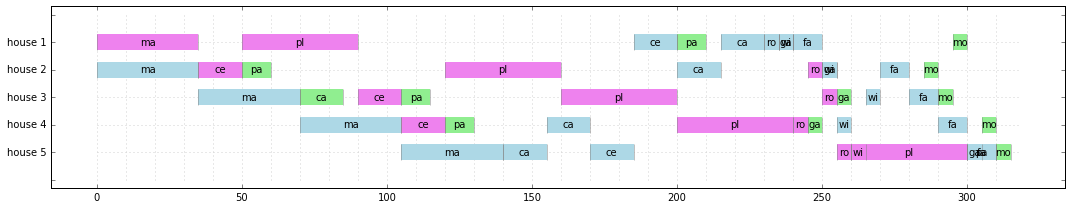

In [54]:
if msol and visu.is_visu_enabled():
    workers_colors = {}
    workers_colors["Joe"] = 'lightblue'
    workers_colors["Jack"] = 'violet'
    workers_colors["Jim"] = 'lightgreen'
    visu.timeline('Solution per houses', 0, MAX_AMOUNT_OF_PERIODS)
    for h in HOUSES:
        visu.sequence(name="house " + str(h))
        for s in SKILLS:
            wt = msol.get_var_solution(wtasks[(h,s)])
            if wt.is_present():
                color = workers_colors[s.worker]
                wtname = compact_name(s.task,2)
                visu.interval(wt, color, wtname)
    visu.show()

The purpose of this function is to compact the names of the different tasks with the aim of making the graphical display readable. </p>
For example "H3-garden" becomes "G3"

In [55]:
def compact_house_task(name):
    loc, task = name[1:].split('-', 1)
    return task[0].upper() + loc

Green-like color when task is using the most skilled worker
Red-like color when task does not use the most skilled worker

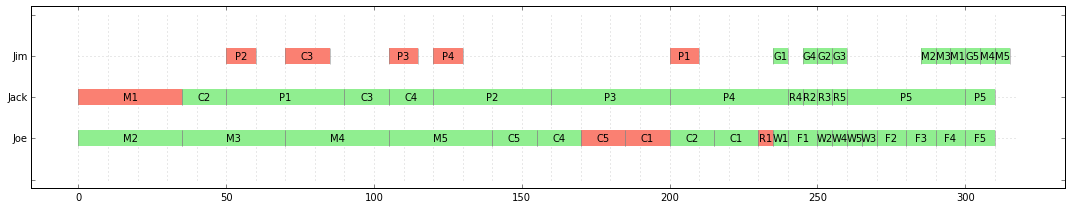

In [56]:
if msol and visu.is_visu_enabled():
    visu.timeline('Solution per workers', 0, MAX_AMOUNT_OF_PERIODS)
    for w in WORKERS:
        visu.sequence(name=w)
        for h in HOUSES:
            for s in SKILLS:
                if s.worker == w:
                    wt = msol.get_var_solution(wtasks[(h,s)])
                    if wt.is_present():
                        ml = find_max_level_skill(s.task).level
                        if s.level == ml:
                            color = 'lightgreen'
                        else:
                            color = 'salmon'
                        wtname = compact_house_task(wt.get_name())
                        visu.interval(wt, color, wtname)
    visu.show()

<h4>Going further with Constraint Programming</h4>

The last available installable package is available on Pypi here: https://pypi.python.org/pypi/docplex

A complete set of modeling examples can be downloaded here: https://github.com/IBMDecisionOptimization/docplex-examples  

## Summary

You learned how to set up and use the IBM Decision Optimization CPLEX Modeling for Python to formulate a Constraint Programming model and solve it with IBM Decision Optimization on the cloud.

## Author

<b>Christiane BRACCHI</b> joined IBM (formerly ILOG) Optimization development team in 1998 and has worked in Constraint Programming since 1989, contributed to the development of the first commercialized constraint programming product. She works on the IBM CP Optimizer engine and its various modeling tools, especially OPL, Concert and Python interface.



## References
* [CPLEX Modeling for Python documentation](https://rawgit.com/IBMDecisionOptimization/docplex-doc/master/docs/index.html)
* [Decision Optimization on Cloud](https://developer.ibm.com/docloud/)
* Need help with DOcplex or to report a bug? Please go [here](https://developer.ibm.com/answers/smartspace/docloud)
* Contact us at dofeedback@wwpdl.vnet.ibm.com

<b>Copyright © 2017 IBM. This notebook and its source code are released under the terms of the MIT License.</b>